<a href="https://colab.research.google.com/github/vo-h/Melting-Point-Prediction/blob/main/data/mp_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
!pip install rdkit-pypi

import pandas as pd
import os
import pickle
from rdkit import Chem

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


 # Assemble Data

raw.csv was provided by pubchem via this [link](https://pubchem.ncbi.nlm.nih.gov/#input_type=list&query=lNMyv4L050jQYuV7ZwOsVKhIUyiW-PVaj3_uFpRu_BeUd8A&collection=compound&alias=PubChem%3A%20PubChem%20Compound%20TOC%3A%20Melting%20Point&page=1741). To better understand the columns that I chose, please refer to [pubhcem's glossary](https://pubchemdocs.ncbi.nlm.nih.gov/glossary).

In [2]:
data = pd.read_csv('/content/gdrive/MyDrive/Data/mp/raw.csv')
data = data[['cid', 'isosmiles', 'mw', 'polararea', 'complexity', 'heavycnt', 'hbonddonor', 'hbondacc', 'rotbonds']]
data.head()

,cid,isosmiles,mw,polararea,complexity,heavycnt,hbonddonor,hbondacc,rotbonds
0,4,CC(CN)O,75.11,46.2,22.9,5,2,2,1
1,6,C1=CC(=C(C=C1[N+](=O)[O-])[N+](=O)[O-])Cl,202.55,91.6,224.0,13,0,4,0
2,11,C(CCl)Cl,98.96,0.0,6.0,4,0,0,1
3,13,C1=CC(=C(C=C1Cl)Cl)Cl,181.40,0.0,94.3,9,0,0,0
4,19,C1=CC(=C(C(=C1)O)O)C(=O)O,154.12,77.8,157.0,11,3,4,1


## Download Melting Point

Check to see if melting points have been collected (in mp.pkl). If not, collect the data. To see how, see this [article](https://towardsdatascience.com/how-to-programmatically-obtain-chemical-data-from-pubchem-59762810eb1) I wrote about interacting with PubChem programmatically. The resulting file is too large to include on GitHub.

In [8]:
if not os.path.exists('/content/gdrive/MyDrive/Data/mp/mp.pkl'):
  sys.setrecursionlimit(10**6)
  melting_point = {}
  for ind, row in data.iterrows():
    mp = requests.get(f"https://pubchem.ncbi.nlm.nih.gov/rest/pug_view/data/compound/{row['cid']}/xml?heading=Melting+Point")
    mp = BeautifulSoup(mp.content, "html.parser")
    mp = mp.find_all('string')
    melting_point[row['cid']] = mp
    if ind % 100 == 0:
      print(f'Done with {ind + 1}/{len(data)}')
  with open("/content/gdrive/MyDrive/Data/mp/mp.pkl", "wb") as mp_file:
    pickle.dump(melting_point, mp_file, protocol=pickle.HIGHEST_PROTOCOL)
else:
  with open("/content/gdrive/MyDrive/Data/mp/mp.pkl", "rb") as mp_file:
    melting_point = pickle.load(mp_file)

# Clean Data

The melting point data is quite messy. For example, there are multiple reports for a single compound. The units don't agree. And there are annotations as well. Here's my strategy:
* Since the dataset is so large, I'm going to ignore any entry that has annotations. These annotations might be along the lines of "it's not pure" or instead of the number, the author gives a range (which might also mean the compound is not pure), etc..
* Then, for those that have different units, I'm going to separate them into farenheit and celcius. Then I convert farenheit to celcius, and if the converted value agrees within 0.5 degrees (to account for numerical errors & human errors when data was recorded), I record the celcius value.
* Finally, even within the same temperature scale, the reported data don't agree. So, any compound that has melting temperatures with a spread beyond a given tolerance degrees are discarded.

In [9]:
def f_to_c(f):
  return round((f - 32)*5/9, 2)

if not os.path.exists('/content/gdrive/MyDrive/Data/mp/clean.csv'):
  data['mp'] = None

  # discard data with spread beyond this tolerance level
  tolerance = 1

  for key in melting_point:
    # Get index to later input data
    index = data[data['cid'] == key].index
  
    # Get all the melting points of a compound
    values = melting_point[key]

    farenheit = []
    celcius = []

    # Get strings that have farenheit/celcius and ignore those with annotations
    for value in values:
      temp = value.get_text()
      if bool(re.search("^[\-|0-9][0-9]*[.]?[0-9]*[ ]*[u'\N{DEGREE SIGN}'][F ]$", temp)):

        temp = temp.split(u'\N{DEGREE SIGN}')[0].strip()
        farenheit.append(float(temp))

      elif bool(re.search("^[\-|0-9][0-9]*[.]?[0-9]*[ ]*[u'\N{DEGREE SIGN}'][C ]$", temp)):

        temp = temp.split(u'\N{DEGREE SIGN}')[0].strip()
        celcius.append(float(temp))
  
    # Situation 1: reports with both T scale
    if farenheit and celcius:
      if np.std(farenheit) < tolerance and np.std(celcius) < tolerance:
        if abs(f_to_c(np.mean(farenheit)) - np.mean(celcius)) < 1:
        
          data.loc[index, 'mp'] = round(np.mean(celcius), 2)

    # Situation 2: reports with only farenheit
    elif farenheit and not celcius:
      if np.std(farenheit) < tolerance:
      
        data.loc[index, 'mp'] = f_to_c(np.mean(farenheit))
  
    # Situation 3: reports with only celcius
    elif celcius and not farenheit:
      if np.std(celcius) < tolerance:

        data.loc[index, 'mp'] = round(np.mean(celcius), 2)

  data = data.dropna().reset_index(drop=True)
  data['mp'] = data['mp'].astype('float64')
  data.to_csv('/content/gdrive/MyDrive/Data/mp/clean.csv', index=False)
else:
  data = pd.read_csv('/content/gdrive/MyDrive/Data/mp/clean.csv')

## Remove Inorganic Molecules

In [13]:
idx = []
for ind, row in data.iterrows():
  molecule = Chem.MolFromSmiles(data.loc[ind, 'isosmiles'])
  try:
    for atom in molecule.GetAtoms():
      atomic_num = atom.GetAtomicNum()
      if atomic_num not in [1, 6, 7, 8, 17, 35, 53]:
        idx.append(ind)
        break
  except:
    idx.append(ind)

data = data.drop(index=idx).reset_index(drop=True)
data.describe()

,cid,mw,polararea,complexity,heavycnt,hbonddonor,hbondacc,rotbonds,mp
count,4124.000000,4124.000000,4124.000000,4124.000000,4124.000000,4124.000000,4124.000000,4124.000000,4124.000000
mean,12848.391610,205.548213,39.627271,197.394421,13.581474,0.836324,2.248788,3.030553,76.484692
std,9698.527331,107.429120,34.445910,168.043547,6.928617,1.118334,1.950438,4.260615,102.786518
min,11.000000,16.043000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,-218.400000
25%,7070.750000,135.160000,17.100000,90.275000,9.000000,0.000000,1.000000,0.000000,5.600000
50%,10706.500000,181.360000,34.500000,154.000000,12.000000,1.000000,2.000000,2.000000,76.400000
75%,15593.250000,251.305000,55.100000,254.250000,17.000000,1.000000,3.000000,4.000000,148.000000
max,60979.000000,1139.800000,332.000000,1910.000000,78.000000,13.000000,19.000000,53.000000,720.000000


## Remove Outliers

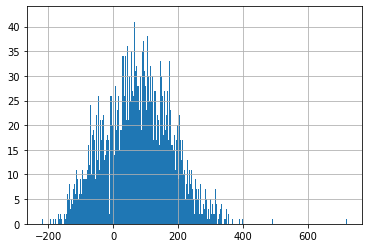

In [14]:
data['mp'].hist(bins=500)

In [16]:
data = data[data['mp'] < 400].reset_index(drop=True)
data.describe()

,cid,mw,polararea,complexity,heavycnt,hbonddonor,hbondacc,rotbonds,mp
count,4120.000000,4120.000000,4120.000000,4120.000000,4120.000000,4120.000000,4120.000000,4120.000000,4120.000000
mean,12854.223058,205.469298,39.643511,197.163421,13.572816,0.836650,2.249757,3.033495,76.061425
std,9700.806713,107.359576,34.450331,167.696223,6.916948,1.118502,1.950716,4.261636,101.860584
min,11.000000,16.043000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,-218.400000
25%,7070.750000,135.160000,17.100000,90.275000,9.000000,0.000000,1.000000,0.000000,5.600000
50%,10708.500000,181.275000,34.950000,154.000000,12.000000,1.000000,2.000000,2.000000,76.000000
75%,15601.000000,251.252500,55.100000,254.000000,17.000000,1.000000,3.000000,4.000000,148.000000
max,60979.000000,1139.800000,332.000000,1910.000000,78.000000,13.000000,19.000000,53.000000,390.000000


In [17]:
data.to_csv('/content/gdrive/MyDrive/Data/mp/organic_clean.csv', index=False)